In [1]:
import pandas as pd
import numpy as np
import dill
import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import Graphs
import networkx as nx
import torch.optim as optim
import random
import copy
import sys
import traceback
from torch.nn import functional as F
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.optimizer import required
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
sns.set_theme(style="whitegrid")

In [2]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [3]:
def createDictFloor(floor_idx,path):
    floorname = [f'Floor{idx}' for idx in floor_idx]
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for name in floorname for floor in fulldata if name in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
        
def createDTFeat(date1, date2, datadict,featureX, featureY,resample_method_X="mean",resample_method_Y = "sum"):
    resample_move = {}
    floors = list(datadict.keys())
    dates = []
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        dataY = datadict[floorname][date1:date2][featureY].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        elif resample_method_X == "max":
            dataX = dataX.resample("5T").max().bfill()
        else:
            pass
        
        if resample_method_Y =="sum":
            dataY = dataY.resample("5T").sum()
        elif resample_method_Y == "mean":
            dataY = dataY.resample("5T").mean().bfill()
        elif resample_method_Y == "max":
            dataY = dataY.resample("5T").max().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX,dataY],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["weekday"] = resample_move[floorname].index.weekday
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
        resample_move[floorname]["time"] = resample_move[floorname].index.time
        resample_move[floorname]["time"] = resample_move[floorname]["time"].apply(lambda x: x.strftime("%H:%M:%S"))
        
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
    
    return resample_move, dates

def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = copy.deepcopy(datadict)
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(scaled_data_dict[floorname][feature])
        scaled_data_dict[floorname][feature] = scaler.transform(scaled_data_dict[floorname][feature])
        scalers[floorname] = scaler
    return scaled_data_dict, scalers

def get_info_timeshape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [106]:
def get_info_zone(datadict):
    for data in datadict.keys():
        zone = datadict[data]
        print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
        print("")
        
def distribution(datadict, feature):
    zone_list = sorted(list(datadict.keys()))
    concat_feature = pd.DataFrame()
    for zone in zone_list:
        concat_feature = pd.concat([concat_feature, datadict[zone][feature].rename(f"{zone}")],axis=1)
    return concat_feature

def delete_zone(datadict,zone_to_delete):
    for zone in zone_to_delete:
        if zone in datadict.keys():
            del datadict[zone]
    return datadict

def plot_data(datadict, cutting_date, feature, feature2=None):
    zone_list = sorted(list(datadict.keys()))
    for zone in zone_list:
        
        plt.figure(figsize=(20,3))
        plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date][feature].values,label=zone)
        if feature2 is not None:
            plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date][feature2].values,label=zone)
        plt.legend()
        plt.show()
        
def remove_weekend(datadict):
    dates = []
    mydict = {}
    for floor_zone in datadict.keys():
        mask_sat = datadict[floor_zone].weekday == 5
        mask_sun = datadict[floor_zone].weekday == 6
        index_rmv = datadict[floor_zone].loc[mask_sat | mask_sun].index
        mydict[floor_zone] = datadict[floor_zone].drop(index_rmv,axis=0)
    for date in mydict[floor_zone]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
    return mydict,dates

def remove_holidays(datadict, holidays_list):
    dates = []
    mydict = copy.deepcopy(datadict)
    for floor in mydict.keys():
        for date in holidays_list:
            mask_date = mydict[floor].date==date
            index_rmv = mydict[floor].loc[mask_date].index
            mydict[floor] = mydict[floor].drop(index_rmv,axis=0)
            
    for date in mydict[floor]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
    return mydict,dates

def working_hour(datadict,morning,evening):
    mydict = copy.deepcopy(datadict)
    for floor in mydict.keys():
        mask_morning = datadict[floor].time >= morning
        mask_evening = datadict[floor].time <= evening
        mydict[floor] = datadict[floor].loc[mask_morning & mask_evening]
        #roll = mydict[floor]["temperature"].rolling(window=7).mean()
        #mydict[floor]["Roll"] = roll
        mydict[floor]["tempdiff"] = mydict[floor]["temperature"].diff()
        mydict[floor]["tempdiff"].fillna(0, inplace=True)
        mydict[floor]["convolve"] = np.convolve(mydict[floor]["tempdiff"],np.ones(5),"same")#np.ones_like(mydict[floor]["tempdiff"]),"same")
        mydict[floor]["Label"] = pd.qcut(mydict[floor]["convolve"],[0,0.25,0.75,1], [2,1,0])
        #mydict[floor]["tempdiff"]
    return mydict

def create_power_class(datadict, conditions, feature):
    keys = sorted(list(datadict.keys()))
    classes = list(conditions[keys[0]].keys())
    new_datadict = copy.deepcopy(datadict)
    encode = encode = {"Low Power": 0, "Mid Power": 1, "High Power": 2}
    for floor_name in keys:
        new_datadict[floor_name]["Label"] = pd.Series(dtype=int)
        #empty_series = pd.Series(dtype='object')
        for p_class in classes:
            #print(p_class)
            mask_p1 = datadict[floor_name][feature] >= conditions[floor_name][p_class][0]
            mask_p2 = datadict[floor_name][feature] < conditions[floor_name][p_class][1]
            idx_classes = datadict[floor_name].loc[mask_p1 & mask_p2]
            #print(idx_classes.index)
            #print(new_datadict[floor_name].loc[idx_classes.index]["Label"])
            assign = new_datadict[floor_name].loc[idx_classes.index]["Label"].apply(lambda x: encode[p_class])
            new_datadict[floor_name]["Label"].loc[idx_classes.index] = assign
            #print(hehe)#new_datadict[floor_name].loc[idx_classes.index]["Label"].apply(lambda x: p_class)
            new_datadict[floor_name]["Spike"] = new_datadict[floor_name][feature].diff()
            new_datadict[floor_name]["SpikeTemp"] = new_datadict[floor_name]["temperature"].diff()
            roll = new_datadict[floor_name]["Spike"].rolling(window=3).mean()
            new_datadict[floor_name]["Roll"] = (roll - np.min(roll))/(np.max(roll)-np.min(roll)+1)
            new_datadict[floor_name]["Spike"].fillna(0, inplace=True)
            new_datadict[floor_name]["SpikeTemp"].fillna(0, inplace=True)
    return new_datadict

In [107]:
holidays = ["2019-04-08","2019-04-12","2019-04-13","2019-04-14","2019-04-15","2019-04-16",
           "2019-05-01"]
set_point = {"Floor4Z1":{"Low Power":[0,15],"Mid Power":[15,25],"High Power":[25,60]},
             "Floor4Z2":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
            "Floor4Z4":{"Low Power":[0,15],"Mid Power":[15,25],"High Power":[25,60]},
            "Floor4Z5":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,60]},
             "Floor5Z1":{"Low Power":[0,15],"Mid Power":[15,25],"High Power":[25,60]},
            "Floor5Z2":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
             "Floor5Z4":{"Low Power":[0,15],"Mid Power":[15,25],"High Power":[25,60]},
             "Floor5Z5":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,50]},
            "Floor6Z1":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,60]},
            "Floor6Z2":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
            "Floor6Z4":{"Low Power":[0,15],"Mid Power":[15,25],"High Power":[25,60]},
            "Floor6Z5":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,60]},
            "Floor7Z1":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
             "Floor7Z2":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
            "Floor7Z4":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
             "Floor7Z5":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,60]}}

# Data

In [398]:
seed_everything(seed=20)
date1 = "2019-03-07"
date2 = "2019-09-29"
cutting_date = "2019-04-20"
floors = [4]
floor_dict = createDictFloor(floors, bkdatafolder)
featureX = ["temperature"]
featureY = ["ACPower"]
resample_method = "mean"
resample_methodY = "max"
resample,remain_date = createDTFeat(date1, date2, floor_dict, featureX, featureY,resample_method_X=resample_method,resample_method_Y=resample_methodY)
resample_wo_holidays, remain_date = remove_holidays(resample, holidays)
resample_wo_wk, remain_date = remove_weekend(resample_wo_holidays)
resample_wkh = working_hour(resample, "07:00:00","18:30:00")
#resample_with_classes = create_power_class(resample_wkh,set_point,*featureY)
scaled_data, scalers = data_scaling(resample_wkh, [*featureX, *featureY])
#scaled_data, scalers = data_scaling(resample, [*featureX, *featureY])

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [399]:
new_scaled = delete_zone(scaled_data, ["Floor4Z2"])#["Floor4Z2","Floor5Z4","Floor5Z5"])
get_info_zone(new_scaled)

Floor4Z5 Start: 2019-03-07 07:00:00 End: 2019-09-29 18:30:00 Count:28773

Floor4Z4 Start: 2019-03-07 07:00:00 End: 2019-09-29 18:30:00 Count:28773

Floor4Z1 Start: 2019-03-07 07:00:00 End: 2019-09-29 18:30:00 Count:28773



In [400]:
for floor in resample_wkh.keys():
    print(resample_wkh[floor]["Label"].value_counts())

1    14390
2     7196
0     7187
Name: Label, dtype: int64
1    14383
2     7212
0     7178
Name: Label, dtype: int64
1    14373
2     7214
0     7186
Name: Label, dtype: int64
1    14384
2     7197
0     7192
Name: Label, dtype: int64


# Loaders

In [401]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            arraydata = datadict[floor].loc[date][features]
            databyDate[date][floor] = np.asarray(arraydata)#np.asarray(datadict[floor].loc[date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))
            
def LoaderByZone(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False, noise=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead)
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(trainy, dtype=torch.float).squeeze(-1)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

def LoaderByZoneXY(dataX, dataY, zone_name,dates, lookback, lookahead, batch_size, shuffle=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        dataX_series = dataX[date][zone_name]
        dataY_series = dataY[date][zone_name]
        trainx,_ = to_timeseries_input(dataX_series, lookback, lookahead)
        _, trainy = to_timeseries_input(dataY_series,lookback, lookahead)
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(trainy, dtype=torch.long).squeeze(-1).squeeze(-1)
        #print(xshape.shape, yshape.shape)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

def get_loader(floor_list,datadatesX, datadatesY, train_date, test_date, lookback, lookahead, batch_size):
    trainloader, testloader = [], []
    nb_zone = 5#*len(floor_list)
    zones = [i for i in range(1,nb_zone+1) if i!=3]
    zones_id = list(datadatesX[train_date[0]].keys())
    for zone in zones_id:#range(1,nb_zone+1):
            print(f'-----{zone}-----')
            loaderZtrain = LoaderByZoneXY(datadatesX, datadatesY,zone,train_date,lookback,lookahead,batch_size, shuffle=True)
            loaderZtest = LoaderByZoneXY(datadatesX, datadatesY,zone,test_date,lookback, lookahead,batch_size, shuffle=False)
            trainloader.append(loaderZtrain)
            testloader.append(loaderZtest)
    return trainloader, testloader, zones_id

In [402]:
train_date, test_date = splitDate(remain_date, cutting_date)
databyDateX = createDataByDate(new_scaled, featureX,remain_date)
databyDateY = createDataByDate(new_scaled, ["Label"],remain_date)

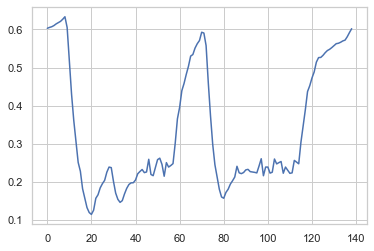

In [403]:
plt.plot(databyDateX["2019-03-07"]["Floor4Z1"].reshape(-1))

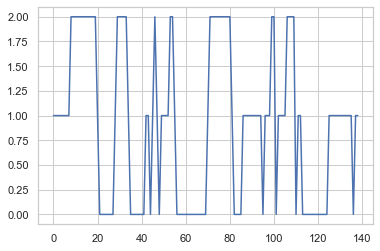

In [404]:
plt.plot(databyDateY["2019-03-07"]["Floor4Z1"].reshape(-1))

In [405]:
lookback = 5
lookahead = 1
batch_size = 32

In [406]:
trainloader, testloader, zone_id = get_loader(floors, databyDateX, databyDateY, train_date, test_date, lookback, lookahead, batch_size)

-----Floor4Z5-----
-----Floor4Z4-----
-----Floor4Z1-----


In [407]:
x,y = iter(testloader[0]["2019-06-20"]).next()
x.shape, y.shape

(torch.Size([32, 5, 1]), torch.Size([32]))

In [408]:
nb_iterations = len(train_date)*len(trainloader[0]["2019-03-08"])
nb_iterations

112

# Algorithm

In [409]:
def lmo(x,radius):
    """Returns v with norm(v, self.p) <= r minimizing v*x"""
    shape = x.shape
    if len(shape) == 4:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            for second_dim in range(shape[1]):
                inner_x = x[first_dim][second_dim]
                rows, cols = x[first_dim][second_dim].shape
                v[first_dim][second_dim] = torch.zeros_like(inner_x)
                maxIdx = torch.argmax(torch.abs(inner_x),0)
                for col in range(cols):
                    v[first_dim][second_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
    elif len(shape) == 3:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            inner_x = x[first_dim]
            rows, cols = x[first_dim].shape
            v[first_dim] = torch.zeros_like(inner_x)
            maxIdx = torch.argmax(torch.abs(inner_x),0)
            for col in range(cols):
                v[first_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
                    
    elif len(shape)==2:
        rows, cols = x.shape
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x),0)
        for col in range(cols):
            v[maxIdx[col],col] = -radius*torch.sign(x[maxIdx[col],col])
                
    else : 
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
    return v
def proj_2shape(x,s=8):
    shape = x.shape
    if torch.linalg.norm(x,ord=1)==s and torch.all(x>0):
        return x
    u,_ = torch.sort(torch.abs(x),dim=0,descending=True)
    cumsum = torch.cumsum(u, dim=0)
    arange = torch.arange(1, shape[0]+1)
    rep_arange = arange.unsqueeze(1).repeat(1,shape[1])
    rho = torch.count_nonzero((u*rep_arange > (cumsum - s)), dim=0)
    theta = (cumsum[rho-1, torch.arange(0,shape[1])] - s)/rho
    proj = (torch.abs(x)-theta).clamp(min=0)
    proj*= torch.sign(x)
    return proj

def proj_l1(x, s=8):
    shape = x.shape
    if len(shape) == 4:
        proj = torch.zeros_like(x)
        for first_dim in range(x.shape[0]):
            for second_dim in range(x.shape[1]):
                inner_tensor = x[first_dim][second_dim]
                inner_proj = proj_2shape(inner_tensor,s=s)
                proj[first_dim][second_dim] = inner_proj
                
    elif len(shape) == 3:
        proj = torch.zeros_like(x)
        for first_dim in range(x.shape[0]):
            inner_tensor = x[first_dim]
            inner_proj = proj_2shape(inner_tensor,s=s)
            proj[first_dim] = inner_proj
        
    elif len(shape) == 2:
        proj = proj_2shape(x,s=s)
        
    elif len(shape) == 1:
        u,_ = torch.sort(torch.abs(x),descending=True)
        cumsum = torch.cumsum(u,dim=0)
        arange = torch.arange(1,shape[0]+1)
        rho = torch.count_nonzero((u*arange > (cumsum - s)))
        theta = (cumsum[rho-1] - s)/rho
        proj = (torch.abs(x)-theta).clamp(min=0)
        proj*= torch.sign(x)
    return proj

In [410]:
class DMFW(optim.Optimizer):
    def __init__(self, params, eta_coef=required, eta_exp=required, L=required, matrix_line=required, reg_coef=required,radius=required):
        if eta_coef is not required and eta_coef <=0.:
            raise ValueError("Invalid eta : {}".format(eta_coef))
        if eta_exp is not required and (eta_exp == 0.5):
            raise ValueError("Invalid eta_exp : {}".format(eta_exp))
        defaults = dict(eta_coef=eta_coef, eta_exp=eta_exp,L=L, matrix_line=matrix_line,reg_coef = reg_coef,radius=radius)
        super(DMFW,self).__init__(params,defaults)

        for group in self.param_groups:
            self.eta_coef = group["eta_coef"]
            self.eta_exp = group["eta_exp"]
            self.reg_coef = group["reg_coef"]
            self.A = group["matrix_line"]
            self.L = group["L"]
            self.radius = group["radius"]
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.G = [[torch.rand(k) for k in self.dim] for l in range(self.L)]
        
    @torch.no_grad()
    def initValue(self,closure):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            for k,weight in enumerate(group["params"]):
                #print(k, weight.shape)
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = weight.grad.detach().clone()
                self.w_dict[k]["w"] = weight.detach().clone()
                
    def neighborsAverage(self, neighbors):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                weighted_tmp = torch.zeros(self.dim[k])
                weighted_grad_tmp = torch.zeros(self.dim[k])
                for j in range(len(neighbors)):
                    weighted_tmp += self.A[j]*neighbors[j].w_dict[k]["w"]
                    weighted_grad_tmp += self.A[j]*neighbors[j].w_dict[k]["g"]
                self.w_dict[k]["y"] = weighted_tmp
                self.w_dict[k]["ds"] = weighted_grad_tmp


    def step(self, l, closure):
        eta = min(self.eta_coef/(l+1)**self.eta_exp, 1)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            self.gap = 0
            for k,weight in enumerate(group["params"]):
                v = proj_l1(self.G[l][k], self.radius)
                #v = lmo(self.G[l][k] - 0.5 + torch.rand_like(self.G[l][k]), radius= self.radius)
                #print(v)
                if weight.grad is None:
                    raise ValueError("Grad is None")
                self.w_dict[k]["grad_old"] = weight.grad.detach().clone()
                
                weight.data = self.w_dict[k]['y']*(1-eta) + eta*v
                #print("weight {}".format(torch.linalg.norm(weight.data,ord=1,dim=0)))
                self.w_dict[k]["w"] = weight.detach().clone()
            
            with torch.enable_grad():
                closure()
            for k,weight in enumerate(group["params"]):
                self.G[l][k] -= self.w_dict[k]["ds"]*self.reg_coef
                #self.G[l][k] -= self.w_dict[k]["ds"]*self.reg_coef
                #self.G[l][k] += self.w_dict[k]["ds"]*self.reg_coef
                if weight.grad is None :
                    raise ValueError("Grad is none")
                weight.grad.add_(-self.w_dict[k]["grad_old"])
                self.w_dict[k]["g"] = weight.grad.detach().clone() + self.w_dict[k]["ds"]

In [414]:
class Trainer:
    def __init__(self, graph, loaders, model, model_param, loss,
                 num_iterations):
        self.graph = graph
        self.num_nodes = graph.number_of_nodes()
        self.model = model
        self.param = model_param
        self.A = torch.tensor(nx.adjacency_matrix(graph).toarray())
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations + 1, 4),
                                     dtype='float')

        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes

    def reset(self):
        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.gaps = [0.] * self.num_nodes
        self.best_models = [0.]*self.num_nodes

        #self.obj_values = np.ndarray((self.num_iterations +1, 8),
        #                             dtype='float')
        
        self.obj_values = np.ndarray((self.num_iterations +1, 4),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes
    
    def initModelWeight(self, model):
        for m in model.modules():
            if isinstance(m, nn.LSTM):
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.xavier_normal_(param.data)
                    else:
                        nn.init.constant_(param.data,0)
            elif isinstance(m,nn.Conv1d):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.constant_(m.bias.data,0)
            elif isinstance(m,nn.BatchNorm1d):
                nn.init.uniform_(m.weight.data)
                nn.init.constant_(m.bias.data,0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.uniform_(m.bias.data)
                #nn.init.constant_(m.bias.data,0)


    def saveCheckPts(self, t, path):
        check_pts = {}
        for i in range(self.num_nodes):
            ckp_i = {
                "t": t,
                "weight": [param for param in self.models[i].parameters()],
                "optimizer_weight": self.optimizers[i].w_dict,
                "oracles": self.optimizers[i].G,
                "loss": self.losses[i]
            }  #,
            #"avg_loss": self.avg_loss[i]}
            check_pts[i] = ckp_i
        torch.save(check_pts, path + "checkpts_models" + "_" + str(t) + ".tar")
        
    def plotPrediction(self, true, pred,date,path_to_save):
        fig = plt.figure(figsize=(5,3))
        plt.suptitle("{}".format(date))
        plt.plot(true)
        plt.plot(pred)
        #plt.show()
        fig.savefig(os.path.join(path_to_save,date))
        plt.close()
        
    def compute_gap(self,model, datax, datay):
        output = model(datax)
        loss = self.loss(output, datay)
        loss.backward()
        

    def train(self, optimizer, L, eta_coef, eta_exp, reg_coef, radius, path_figure_date, print_freq, dates):
        seed_everything(seed=20)
        self.reset()

        for i in range(self.num_nodes):
            self.models[i] = self.model(*self.param)
            self.optimizers[i] = optimizer(self.models[i].parameters(),
                                           eta_coef=eta_coef,
                                           eta_exp=eta_exp,
                                           L=L,
                                           matrix_line=self.A[i],
                                           reg_coef=reg_coef,
                                           radius=radius)
            self.best_models[i] = copy.deepcopy(self.models[i])

        self.final_gap = np.zeros(self.num_nodes) #[0.] * self.num_nodes
        
        t = 0
        self.prediction_dict = {}
        for date in dates:
            acc,f1,prec,rec = 0, 0, 0, 0
            try:
                '''
                #acc_node = [0.]*self.num_nodes
                f1_node = [0.]*self.num_nodes
                prec_node = [0.]*self.num_nodes
                rec_node = [0.]*self.num_nodes
                for i,loader in enumerate(self.dataloader):
                    acc_node[i], f1_node[i], prec_node[i], rec_node[i], _ , _, _  = ModelPredictionClass(self.best_models[i], date, loader)
                    #if len(truez)==0 or len(predz)==0 : continue
                acc = np.mean(acc_node)
                f1  = np.mean(f1_node)
                prec = np.mean(prec_node)
                rec = np.mean(rec_node)'''
                for i in range(self.num_nodes):
                    truez, predz = ModelPrediction(self.best_models[i], date, self.dataloader[i],lookahead)
                    path = path_figure_date+"/Model_"+str(i)+"/"
                    if not os.path.exists(path):
                        os.makedirs(path)
                    self.plotPrediction(truez, predz,date,path_to_save=path)
            
            
            except Exception:
                #traceback.print_exc()
                if print_freq == 1:
                    print(f"----{date}----")
                pass
            loaderz = []
            for i in range(self.num_nodes):
                loaderz.append(self.dataloader[i][date])
            
            for couples in zip(*loaderz):
                #print(couples[0][1].shape, couples[1][0].shape)
                all_data_x = torch.cat([couples[i][0] for i in range(len(couples))],dim=0)
                all_data_y = torch.cat([couples[i][1] for i in range(len(couples))],dim=0)
                datazones = [self.__nodeInit(*couples[i]) for i in range(len(couples))] 
                
                #print(all_data_x.shape, all_data_y.shape)
                

                for i in range(self.num_nodes):
                    self.initModelWeight(self.models[i])
                    self.models[i].train()

                    def closure():
                        self.optimizers[i].zero_grad(set_to_none=True)
                        x, y = iter(datazones[i]).next()
                        output = self.models[i](x)
                        loss = self.loss(output,y)
                        loss.backward()

                    self.optimizers[i].initValue(closure)
                
                opt_index = np.random.randint(low=0,high=L, size=1)
                
                for l in range(L):
                    #print("--------------------------")
                    
                    if l==opt_index:
                        for i in range(self.num_nodes):
                            self.best_models[i] = copy.deepcopy(self.models[i])

                    #neighbors communication
                    for i in range(self.num_nodes):
                        self.optimizers[i].neighborsAverage(self.optimizers)
                        
                    #update
                    for i in range(self.num_nodes):
                        
                        def closure():
                            self.optimizers[i].zero_grad(set_to_none=True)
                            x, y = iter(datazones[i]).next()
                            output = self.models[i](x)
                            loss = self.loss(output, y)
                            loss.backward()
                            
                        self.optimizers[i].step(l, closure)

                self.gaps_off = [0.] * self.num_nodes
                for i in range(self.num_nodes):
                    with torch.enable_grad():
                        #self.best_models[i].eval()
                        #x, y = iter(datazones[i]).next()
                        self.best_models[i].zero_grad(set_to_none=True)
                        outputs= self.best_models[i](all_data_x)
                        _, predicted = torch.max(outputs.data, 1)
                        #print("------------")
                        self.prediction_dict[t] = Counter(predicted.numpy())
                        #print(f"Prediction Model {i} {Counter(predicted.numpy())}")
                        #print(f"Truth Model {i} {Counter(all_data_y.numpy())}")
                        #print("------------")
                        curr_loss = self.loss(outputs,all_data_y)
                        curr_loss.backward()
                        for param in self.best_models[i].parameters():
                            if param.grad is None:
                                raise ValueError("Grad is None")
                            a = lmo(param.grad.data,radius=radius)
                            self.gaps_off[i] += torch.sum(torch.mul(param.grad.data, param.data - a))
                
                    #self.final_gap[i] += self.optimizers[i].init_gap
                    #self.final_gap[i] /= (t + 1)
                    #self.gaps_off[i] = self.optimizers[i].init_gap
                    self.final_gap[i] += self.gaps_off[i]
                    self.losses[i] = curr_loss.detach().numpy()
                #print(self.final_gap)
                loss = np.max(self.losses)
                gap = np.max(self.final_gap/(t+1))  #.detach().numpy(
                local_gap = np.max(self.gaps_off)
                '''
                if t % print_freq == 0:
                    print("t_{} : loss : {:.5f} gap : {:.5f} local-gap : {:.5f} acc {:.5f} f1 {:.5f} precision {:.5f} recall {:.5f}".format(
                        t, loss, gap,local_gap,acc, f1, prec, rec))
                    
                self.obj_values[t, :] = [t, loss, gap,local_gap ,acc, f1, prec, rec]'''
                if t % print_freq == 0:
                    print("t_{} : loss : {:.5f} Gap : {:.5f} Local-Gap : {:.5f}".format(
                        t, loss, gap, local_gap))
                    
                self.obj_values[t, :] = [t, loss, gap, local_gap]
                    
                t+=1

        return self.obj_values

In [415]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, time_step_in, time_step_out):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1
        
        self.encoder = nn.LSTM(self.input_size, self.hidden_size1,
                               num_layers=self.num_layers, batch_first=True, bias=True)
        self.encoder2 = nn.LSTM(self.hidden_size1, self.hidden_size2, num_layers=1, batch_first=True, bias=True)
        
        self.batch = nn.BatchNorm1d(self.hidden_size2)
    
        self.linear2 = nn.Linear(self.hidden_size2, 3,bias=True)
        
    def forward(self,x):
        out_en, (h_en) = self.encoder(x)
        out_en, (h_en) = self.encoder2(out_en)
        out_en = out_en[:,-1,:]
        out_en = self.batch(out_en)
        out = nn.LeakyReLU()(out_en)
        out = self.linear2(out)
        return out
    
class CNN1D(nn.Module):
    def __init__(self,nb_chan_out, nb_classes, input_len,kernel_size):
        super(CNN1D, self).__init__()
        self.input_len = input_len
        
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=nb_chan_out, kernel_size=kernel_size, stride=1, 
                                padding=int(np.floor(kernel_size/2)))
        self.conv1d2 = nn.Conv1d(in_channels=nb_chan_out, out_channels=nb_chan_out, kernel_size=3, stride=1, 
                                padding=int(np.floor(3/2)))
        
        
        self.maxpool = nn.MaxPool1d(3)
        self.batchnorm = nn.BatchNorm1d(nb_chan_out)
        self.fc1 = nn.Linear(nb_chan_out*int((input_len/3)),nb_classes, True)
        
    def forward(self, x):
        inputs = x.permute(0,2,1)
        out = self.conv1d(inputs)
        out = self.conv1d2(out)
        out = self.batchnorm(out)
        out = self.maxpool(out)
        out = nn.ReLU()(out)
        
        out = out.view(-1, out.shape[1]*out.shape[2])
        
        out = self.fc1(out)
        return out

In [413]:
lstm = LSTM(1,64,64, lookback, lookahead)
cnn = CNN1D(8,3,lookback,5)
x, y = iter(trainloader[0]["2019-03-08"]).next()
summary(cnn, x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    --                        --
├─Conv1d: 1-1                            [32, 8, 5]                48
├─Conv1d: 1-2                            [32, 8, 5]                200
├─BatchNorm1d: 1-3                       [32, 8, 5]                16
├─MaxPool1d: 1-4                         [32, 8, 1]                --
├─Linear: 1-5                            [32, 3]                   27
Total params: 291
Trainable params: 291
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [416]:
complete_graph, complete = Graphs.completegraph(len(trainloader))
cycle_graph, cycle = Graphs.cycle_graph(len(trainloader))
grid_graph, grid = Graphs.gridgraph(int(len(trainloader)/2),2)
line_graph, line = Graphs.gridgraph(len(trainloader),1)
grid11,_ = Graphs.gridgraph(1,1)

In [417]:
#loss_fn = nn.SmoothL1Loss()
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
num_iters_base = nb_iterations
eta_coef_DMFW = 1
eta_exp_DMFW = 0.99
rho_coef_DMFW = 4e-0
rho_exp_DMFW = 1/2
reg_coef_DMFW = 2
L_DMFW = nb_iterations #or nb_iteration to get a better resu

In [209]:
def save_log_csv(log_file, path_to_save):
    #logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap", "Local Gap","Acc","F1",'Prec','Rec'])
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap", "Local Gap"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'Floor_log.csv'))
def save_state_dict(model, model_idx, path_to_save):
    torch.save(model.state_dict(), os.path.join(path_to_save,f'model{model_idx}_statedict.pt'))

In [162]:
def grid_search(alpha_list, graph_type):
    for alpha in alpha_list:
        trainXMFW = Trainer(complete_graph,trainloader,CNN1D,(8,3,lookback,alpha), loss_fn ,num_iters_base)
        values_dmfw = trainXMFW.train(DMFW, L_DMFW, eta_coef_DMFW, eta_exp_DMFW, reg_coef=reg_coef_DMFW,radius=1,
                            path_figure_date=None,print_freq=1, dates=train_date)#"./OnlineModel/LSTM/complete1/")
        path_log = f"/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/tempAC-class-version4/DMFW/complete/floor4/alpha095-cut20april-nb_chan{alpha}"
        if not os.path.exists(path_log):
            os.makedirs(path_log)
            
        save_log_csv(values_dmfw, path_log)
        for i in range(len(trainXMFW.best_models)):
            save_state_dict(trainXMFW.best_models[i],i, path_log)
        
        print(np.mean(values_dmfw[:,1][:-1]))
        '''
        indexroom = 0
        mymodel = trainXMFW.best_models[indexroom]
        #real_index_zone = [1,2,4,5]
        #testloader = [loaderZ1test]#, loaderZ2test, loaderZ4test, loaderZ5test]
        may = [date for date in test_date if '2019-04' in date or '2019-05' in date]
        myfloor = zone_id
        resultpd = PredictionMultipleDate(mymodel,test_date,may[0], may[-1],testloader[indexroom], lookahead, scalers,
                                         myfloor[indexroom])
        pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-{myfloor[indexroom]}.csv')'''
        
        print(f"------Done for Hidden {alpha}-------")

In [115]:
#grid_search(alphas, grid11)

In [49]:
path_log = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/tempAC-class-version4/DMFW/cycle/floor4/alpha095-cut20april-spike"
if not os.path.exists(path_log):
    os.makedirs(path_log)

In [446]:
trainXMFW = Trainer(complete_graph,trainloader,CNN1D,(8,3,lookback,5), loss_fn ,num_iters_base)

In [447]:
values_dmfw = trainXMFW.train(DMFW, L_DMFW, eta_coef_DMFW, eta_exp_DMFW, reg_coef=reg_coef_DMFW,radius=1,
                            path_figure_date=None,print_freq=1, dates=train_date)#"./OnlineModel/LSTM/complete1/")

----2019-03-07----
t_0 : loss : 1.09886 Gap : 0.15917 Local-Gap : 0.15917
t_1 : loss : 1.09843 Gap : 0.21748 Local-Gap : 0.27779
t_2 : loss : 1.10707 Gap : 0.22082 Local-Gap : 0.22797
t_3 : loss : 1.10606 Gap : 0.22507 Local-Gap : 0.23783
----2019-03-08----
t_4 : loss : 1.09502 Gap : 0.19022 Local-Gap : 0.06365
t_5 : loss : 1.09162 Gap : 0.16843 Local-Gap : 0.06065
t_6 : loss : 1.10695 Gap : 0.17342 Local-Gap : 0.23015
t_7 : loss : 1.11446 Gap : 0.20123 Local-Gap : 0.39584
----2019-03-11----
t_8 : loss : 1.10128 Gap : 0.20349 Local-Gap : 0.22162
t_9 : loss : 1.05340 Gap : 0.19721 Local-Gap : 0.14072
t_10 : loss : 1.06467 Gap : 0.19755 Local-Gap : 0.20093
t_11 : loss : 1.05165 Gap : 0.19053 Local-Gap : 0.11331
----2019-03-12----
t_12 : loss : 1.08430 Gap : 0.19059 Local-Gap : 0.19223
t_13 : loss : 1.10328 Gap : 0.19928 Local-Gap : 0.31226
t_14 : loss : 1.12576 Gap : 0.21641 Local-Gap : 0.46366
t_15 : loss : 1.11674 Gap : 0.23254 Local-Gap : 0.48248
----2019-03-13----
t_16 : loss : 1.083

In [72]:
save_log_csv(values_dmfw, path_log)
for i in range(len(trainXMFW.best_models)):
    save_state_dict(trainXMFW.best_models[i],i, path_log)

In [455]:
hehe = pd.DataFrame(trainXMFW.prediction_dict).T

In [456]:
hehe.to_csv("./powerclassification.csv")

Text(0, 0.5, 'Gap')

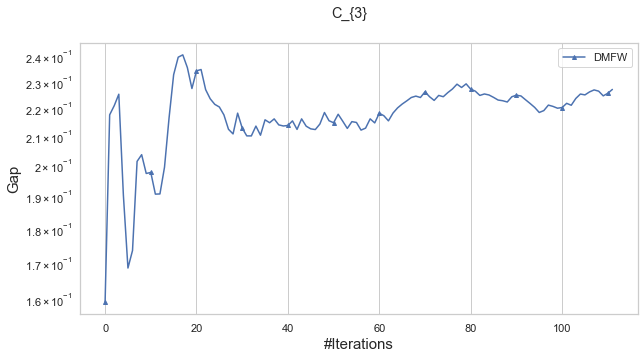

In [448]:
plt.figure(figsize=(10,5))
plt.suptitle("{}".format(cycle))
plt.plot(values_dmfw[:,0][:-1],values_dmfw[:,2][:-1], label='DMFW', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-4, 1e0))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Gap",fontsize=15)

In [449]:
np.mean(values_dmfw[:,1][:-1])

1.0775614327618055

In [437]:
onlineloss = np.cumsum(values_dmfw[:,1][:-1])
arangement = np.arange(1,len(onlineloss)+1)
onlineloss = onlineloss/arangement

In [438]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

In [450]:
plt.figure(figsize=(10,5))
#plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,4][:-1]), label='Online Accuracy', marker='^', markersize=4,
#         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,5][:-1]), label='Online F1-Score', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,6][:-1]), label='Online Precision', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,7][:-1]), label='Online Recall', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.legend(loc='lower right')
#plt.yscale("log")
plt.xlabel("Iterations",fontsize=15)
plt.ylabel("Accuracy/F1",fontsize=15)

IndexError: index 5 is out of bounds for axis 1 with size 4

<Figure size 720x360 with 0 Axes>

Text(0, 0.5, 'Loss')

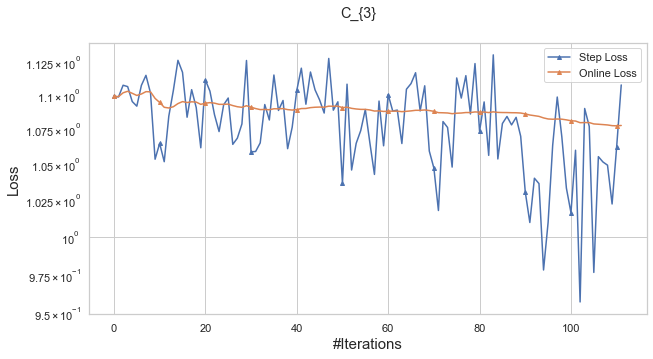

In [451]:
plt.figure(figsize=(10,5))
plt.suptitle("{}".format(cycle))
plt.plot(values_dmfw[:,0][:-1],values_dmfw[:,1][:-1], label='Step Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:-1])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,1][:-1]), label='Online Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-3, 1e2))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Loss",fontsize=15)

# Prediction

In [426]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    for val, valpred in loader[date]:
        model_to_test.eval()
        pred = model_to_test(val)
        #print(pred.shape)
        prediction.append(pred.detach().numpy())
        true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    #print(pred_array.shape)
    pred_shape = pred_array.shape
    #print(pred_shape)
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

def ModelPredictionClass(model_to_test, date ,loader):
    correct = 0
    total = 0
    f1 = 0
    true_array = []
    pred_array = []
    model_to_test.eval()
    with torch.no_grad():
        for series, label in loader[date]:
            outputs = model_to_test(series)
            _, predicted = torch.max(outputs,1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            true_array.append(label.detach().numpy())
            pred_array.append(predicted.detach().numpy())
        truth_roll = np.hstack(true_array).flatten()
        pred_roll = np.hstack(pred_array)
        
        classes_truth = Counter(truth_roll)
        classes_pred = Counter(pred_roll)
        
        #print(f"Truth : {classes_truth}, Pred : {classes_pred}")
        
        f1 = f1_score(truth_roll, pred_roll, average='weighted',labels=np.unique(truth_roll))
        precision = precision_score(truth_roll, pred_roll, average='weighted', labels=np.unique(truth_roll))
        recall = recall_score(truth_roll, pred_roll, average='weighted',labels=np.unique(truth_roll))
        conf_mat = confusion_matrix(truth_roll, pred_roll)
        accuracy = correct/total
    return accuracy, f1 , precision, recall, conf_mat, truth_roll, pred_roll

def plotprediction(pandas,feature): 
    plt.figure(figsize=(15,5))
    plt.title(f'{myfloor[indexroom]}')
    plt.plot(pandas["Truth"],label="Truth")
    plt.plot(pandas["Prediction"],label="Prediction",ls='-')
    plt.xticks(ticks=np.arange(pandas.shape[0],step=100))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel(f'{feature}')
    plt.show()

In [427]:
def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        true = true.repeat(2).reshape((true.shape[0],2))
        pred = pred.repeat(2).reshape((true.shape[0],2))
        maxi = scalers[zone_name].data_max_
        mini = scalers[zone_name].data_min_
        #data_range = 1
        #true = ((true.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        #pred = ((pred.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        #true = scalers[zone_name].inverse_transform(true)[:,1].reshape(-1,1)
        #pred = scalers[zone_name].inverse_transform(pred)[:,1].reshape(-1,1)
        true = true[:,1].reshape(-1,1)
        pred = pred[:,1].reshape(-1,1)
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [428]:
#real_index_zone = [1,2,4,5,1,2,4,5]
myfloor = zone_id#sorted(list(scaled_data.keys()))
may = [date for date in test_date if '2019-05' in date or "2019-04" in date]
for indexroom in range(len(trainXMFW.best_models)):
    mymodel = trainXMFW.best_models[indexroom]
    resultpd = PredictionMultipleDate(mymodel,test_date,may[0], may[10],testloader[indexroom], lookahead, scalers,
                                     myfloor[indexroom])
    plotprediction(resultpd, *featureY)
    #pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-{myfloor[indexroom]}.csv')

ValueError: cannot reshape array of size 384 into shape (128,1)

In [457]:
test_acc = []
test_f1 = []
test_prec = []
test_rec = []
prediction = []
truth = []
model_idx = 1
real_index_zone = [1,2,4,5]
date_to_test = test_date[:10]
for i,date in enumerate(date_to_test):
    #print(f'-----{test_date[i]}-----')
    date_acc, date_f1, date_prec, date_rec, conf_mat, true, pred = ModelPredictionClass(trainXMFW.best_models[model_idx], test_date[i], testloader[model_idx])
    conf_mat = pd.DataFrame(conf_mat)
    test_acc.append(date_acc)
    test_f1.append(date_f1)
    test_prec.append(date_prec)
    test_rec.append(date_rec)
    #print(len(true))
    truth.append(true)
    prediction.append(pred)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

In [458]:
scorepd = pd.DataFrame({"Test Acc": test_acc, 
                        "Test F1": test_f1, 
                        "Test Precision":test_prec, 
                        "Test Recall":test_rec})

#real_val = resample_data[f'Floor7Z{real_index_zone[model_idx]}'].loc[resample_data[f'Floor7Z{real_index_zone[model_idx]}'].apply(lambda x: x.date in date_to_test, axis=1)]
resultpd = pd.DataFrame({"Prediction": np.asarray(prediction).flatten(),
                         "Truth": np.asarray(truth).flatten()})
                        #"RealValue":get_real_dataset(date_to_test,model_idx)})

In [459]:
scorepd

,Test Acc,Test F1,Test Precision,Test Recall
0,0.554688,0.395807,0.307678,0.554688
1,0.453125,0.282594,0.205322,0.453125
2,0.484375,0.316118,0.234619,0.484375
3,0.414062,0.242490,0.171448,0.414062
4,0.460938,0.290859,0.212463,0.460938
5,0.585938,0.432959,0.343323,0.585938
6,0.523438,0.359696,0.273987,0.523438
7,0.367188,0.197232,0.134827,0.367188
8,0.390625,0.219452,0.152588,0.390625
9,0.101562,0.018728,0.010315,0.101562


In [371]:
Counter(resultpd["Truth"])

Counter({0: 364, 1: 416, 2: 500})

In [372]:
Counter(resultpd["Prediction"])

Counter({2: 601, 1: 679})

<AxesSubplot:>

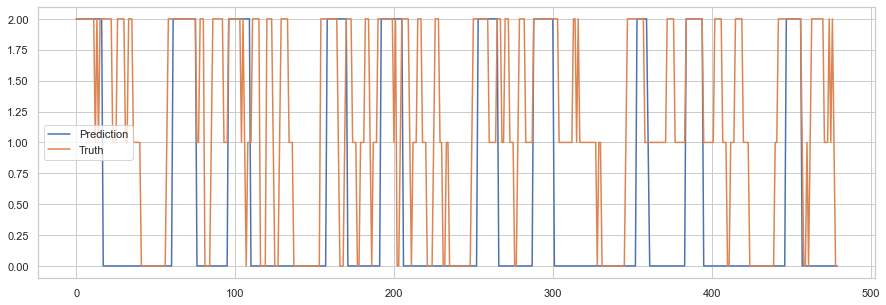

In [161]:
resultpd.plot(figsize=(15,5))

<AxesSubplot:>

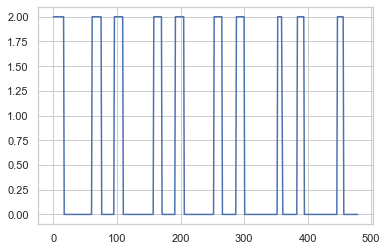

In [162]:
resultpd["Prediction"].plot()

In [269]:
hehe = resample_with_classes["Floor4Z5"].loc[resample_with_classes['Floor4Z5'].date == test_date[0]]["Spike"].values

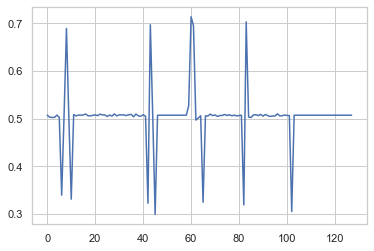

In [99]:
plt.plot(true)

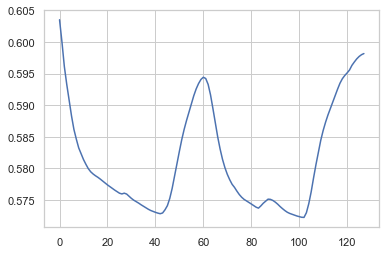

In [98]:
#plt.plot(hehe)
plt.plot(pred)
#plt.plot(true)

In [97]:
true, pred = ModelPrediction(trainXMFW.best_models[0],test_date[0],testloader[0],1)

In [164]:
from scipy.signal import find_peaks, find_peaks_cwt

In [165]:
peaks,_= find_peaks(resultpd["Prediction"])#, widths=np.ones(resultpd["Prediction"].shape[0])*2)-1

In [166]:
peakstruth,_ = find_peaks(resultpd["Truth"])#,widths=np.ones(resultpd["Prediction"].shape[0])*2)-1

{1, 1277}

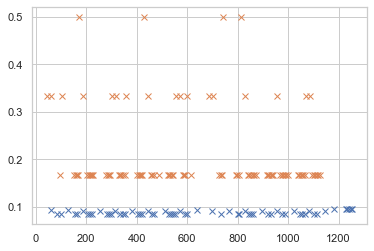

In [492]:
plt.plot(peaks, resultpd["Prediction"][peaks],"x")
plt.plot(peakstruth, resultpd["Truth"][peakstruth],"x")

In [447]:
peaks, peakstruth

(array([   1,   60,  126,  188,  255,  316,  383,  444,  510,  572,  640,
         700,  767,  828,  894,  956, 1023, 1084, 1153, 1181, 1213, 1229,
        1233, 1242, 1253, 1261, 1277]),
 array([   1,   42,   53,   63,  100,  110,  129,  157,  166,  191,  225,
         257,  283,  299,  319,  335,  345,  355,  385,  405,  447,  461,
         470,  513,  530,  554,  576,  590,  600,  641,  682,  693,  703,
         734,  769,  810,  831,  861,  897,  922,  933,  959,  977,  988,
        1025, 1046, 1057, 1066, 1087, 1102, 1114, 1277]))

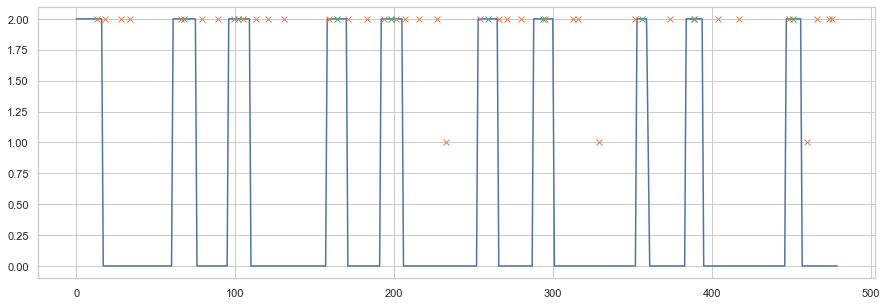

In [168]:
plt.figure(figsize=(15,5))
plt.plot(resultpd["Prediction"])
plt.plot(peakstruth, resultpd["Truth"][peakstruth],"x")
plt.plot(peaks, resultpd["Prediction"][peaks],"x")
plt.show()

In [417]:
pred = pd.DataFrame(resultpd["Truth"])


In [418]:
mini = pred[(pred.shift(5)>pred) & (pred.shift(-5)>pred)].fillna(0)

In [412]:
mini = pred[(pred.shift(2)<pred) & (pred.shift(-2)<pred)].fillna(0)

In [413]:
mini.shape

(1280, 1)

In [420]:
Counter(mini["Truth"])

Counter({0.0: 1139, 0.09090909361839294: 139, 0.1818181872367859: 2})

In [416]:
resultpd["Truth"]

0       0.363636
1       0.363636
2       0.363636
3       0.363636
4       0.181818
          ...   
1275    0.181818
1276    0.181818
1277    0.181818
1278    0.181818
1279    0.181818
Name: Truth, Length: 1280, dtype: float32

0.24113974